In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import cv2
from PIL import Image
from sklearn.metrics import accuracy_score

In [2]:
train_path = './Dataset_2/Train/'
test_path = 'Dataset_2/Test/'
data_dir = './Dataset_2'

train_lable = 'Dataset_2/Train.csv'
test_lable = 'Dataset_2/Test.csv'

In [3]:
NUM_CATEGORIES = len(os.listdir(train_path))
NAME_CATEGORIES = os.listdir(train_path)
print(NUM_CATEGORIES)
print(NAME_CATEGORIES)

43
['12', '16', '19', '32', '28', '30', '40', '24', '4', '2', '14', '38', '9', '20', '3', '41', '7', '0', '17', '39', '34', '22', '33', '8', '42', '1', '5', '27', '31', '26', '10', '25', '35', '6', '36', '15', '37', '23', '21', '18', '11', '29', '13']


In [4]:
# Resizing the images to 30x30x3
IMG_HEIGHT = 30
IMG_WIDTH = 30
channels = 3

In [5]:
# move resize
image_data = []
image_labels = []

for i in range(NUM_CATEGORIES):
    path = data_dir + '/Train/' + str(i)
    images = os.listdir(path)
    for img in images:
        try:
            image = cv2.imread(path + '/' + img)
            image_fromarray = Image.fromarray(image, 'RGB')
            #列表不够整齐，如果创建多维列表，子列表中的元素得个数一致，如果不一致，那么默认还是一维列表，把子列表当做元素而已
            resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))      
            imgray = cv2.cvtColor(np.array(resize_image), cv2.COLOR_BGR2GRAY)
            equ = cv2.equalizeHist(imgray)
            flat_arr=equ.ravel()
            image_data.append(flat_arr)
            image_labels.append(i)
        except:
            print("Error in " + img)

In [6]:
test = pd.read_csv(data_dir + '/Test.csv')
labels = test["ClassId"].values
imgs = test["Path"].values
test_data =[]
for img in imgs:
    try:
        image = cv2.imread(data_dir + '/' +img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
        imgray = cv2.cvtColor(np.array(resize_image), cv2.COLOR_BGR2GRAY)
        equ = cv2.equalizeHist(imgray)
        flat_arr=equ.ravel()
        test_data.append(np.array(flat_arr))
    except:
        print("Error in " + img)

In [7]:
X_test = np.array(test_data)
X_test = X_test/255

In [8]:
img_dict={"images":np.array(imgray),"data":np.array(image_data),"target":np.array(image_labels)}
train = img_dict['data']/255

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train, img_dict['target'], test_size=0.3, random_state=0, shuffle=True)

In [10]:
# 95% of variance
from sklearn.decomposition import PCA
# pca = PCA(n_components = 0.95)
pca=PCA(n_components=100,whiten=True,random_state=0)
pca.fit(X_train)
pca.fit(X_val)
pca.fit(X_test)
X_train_pca = pca.transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

dtc = DecisionTreeClassifier(random_state=0)
rfc = RandomForestClassifier(random_state=0)
dtc = dtc.fit(X_train_pca,y_train)
rfc = rfc.fit(X_train_pca,y_train)
score_c = dtc.score(X_val_pca,y_val)
score_r = rfc.score(X_val_pca,y_val)
print("Single Tree:{}".format(score_c),"Random Forest:{}".format(score_r))

Single Tree:0.41094958769021506 Random Forest:0.7980957238799626


In [12]:
dtc_pred = dtc.predict(X_test_pca)
rf_pred = rfc.predict(X_test_pca)

#Accuracy with the test data
print('Single Tree Test Data accuracy: ',accuracy_score(labels,dtc_pred))
print('Randomforest Test Data accuracy: ',accuracy_score(labels,rf_pred))

Single Tree Test Data accuracy:  0.29612034837688045
Randomforest Test Data accuracy:  0.6006334125098971


In [13]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB().fit(X_train_pca,y_train)
score = gnb.score(X_val_pca,y_val)
print('准确率：',score)

准确率： 0.6433732891269234


In [14]:
gnb_pred = gnb.predict(X_test_pca)
print('Gaussian naive bayes Test Data accuracy: ',accuracy_score(labels,gnb_pred))

Gaussian naive bayes Test Data accuracy:  0.5665083135391924


In [15]:
from sklearn.svm import SVC
svc = SVC(kernel="linear",random_state=0)
svc.fit(X_train_pca, y_train)#训练
y_predict = svc.predict(X_val_pca)#预测
print(accuracy_score(y_val, y_predict))#评分

0.9111621185071835


In [16]:
svc_pred = svc.predict(X_test_pca)
print('SVC Test Data accuracy: ',accuracy_score(labels,svc_pred))

SVC Test Data accuracy:  0.8073634204275535


In [17]:
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier(n_neighbors=9)
knn.fit(X_train_pca,y_train)
y_predict = svc.predict(X_val_pca)
print(accuracy_score(y_val, y_predict)) #评分

0.9111621185071835


In [18]:
knn_pred = knn.predict(X_test_pca)
print(accuracy_score(labels,knn_pred))

0.5007125890736343


confusion_matrix is:
[[  8  39   0 ...   1   0   0]
 [  8 616  34 ...   0   0   0]
 [  1  38 646 ...   0   0   0]
 ...
 [  0   2   1 ...  38   0   0]
 [  0   0   2 ...   0  38   0]
 [  0   0   2 ...   0  11  68]]


<AxesSubplot:>

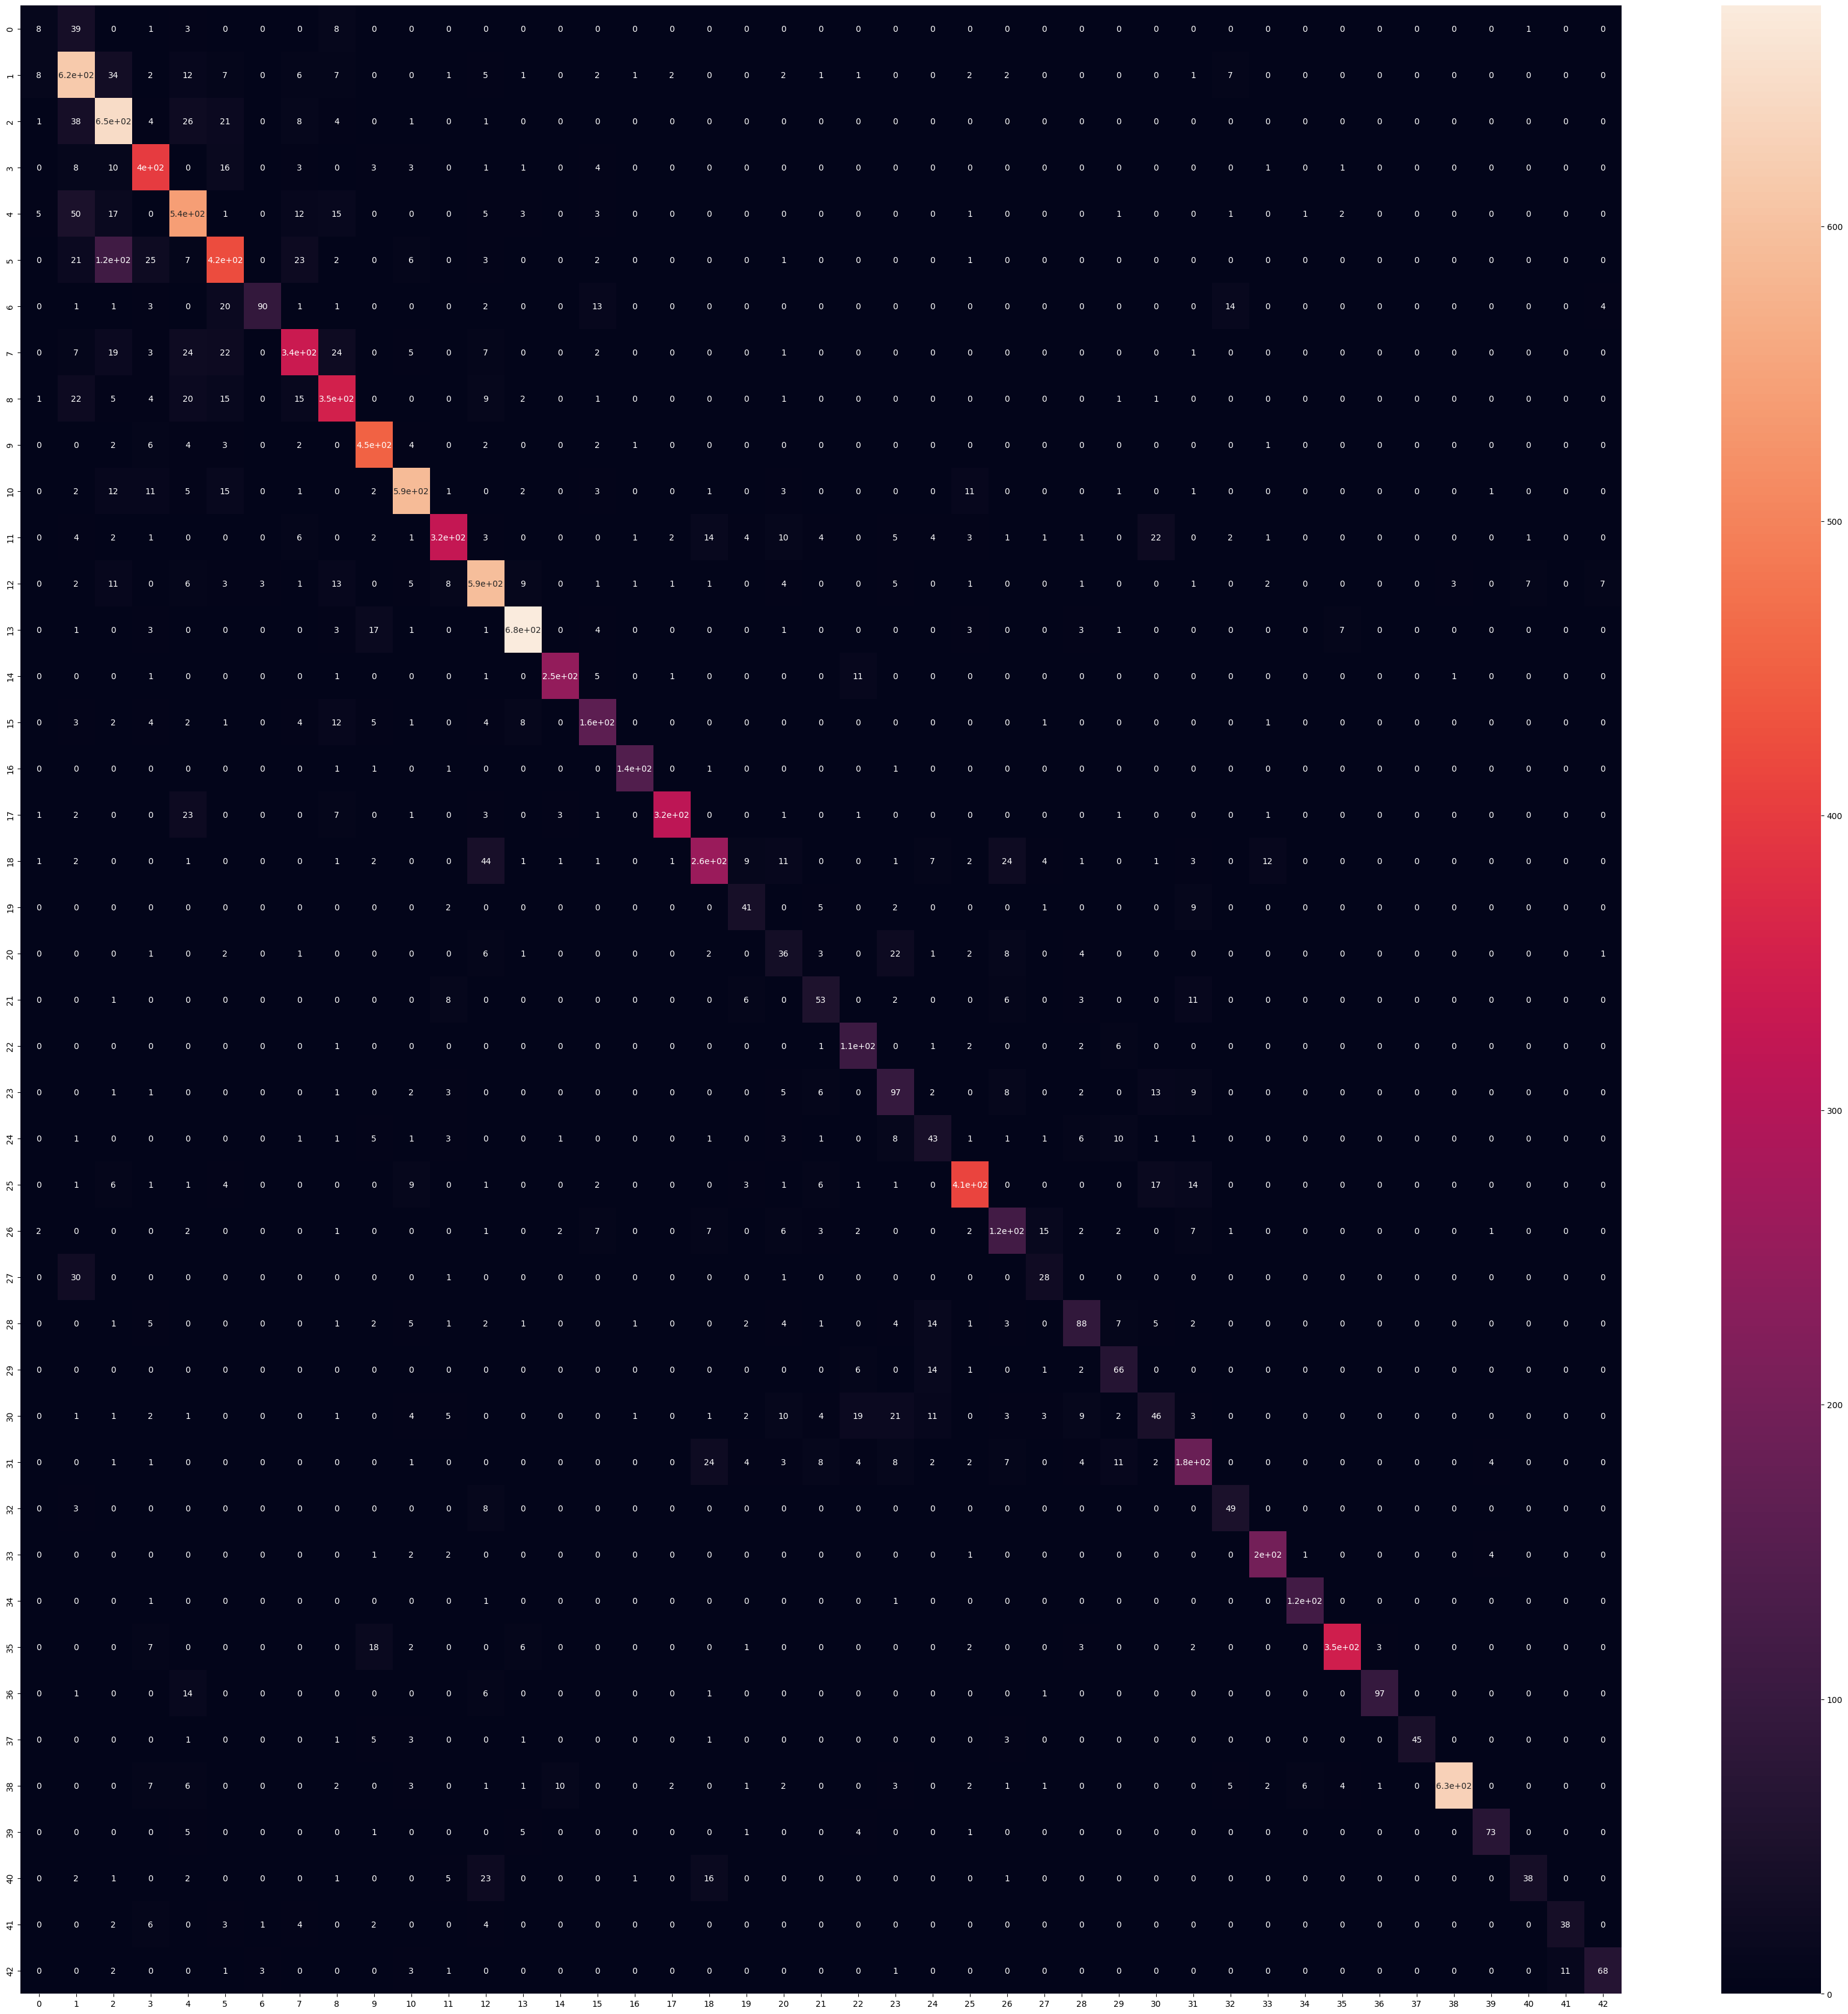

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(labels, svc_pred)
print(f'confusion_matrix is:\n{cm}')
plt.figure(figsize = cm.shape)
sns.heatmap(cm, annot=True)

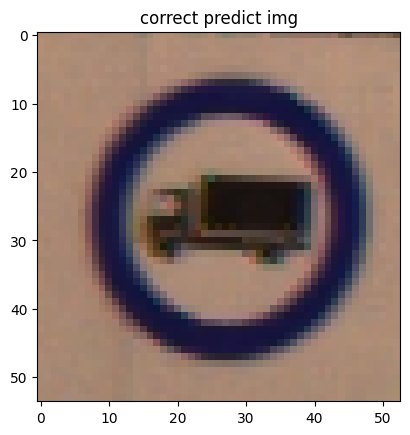

In [20]:
import matplotlib.pyplot as plt

for i in range(0,len(labels)):
    if labels[i] ==svc_pred[i]:
        image = cv2.imread(data_dir + '/' +imgs[i])
        plt.title('correct predict img')
        plt.imshow(image)
        break

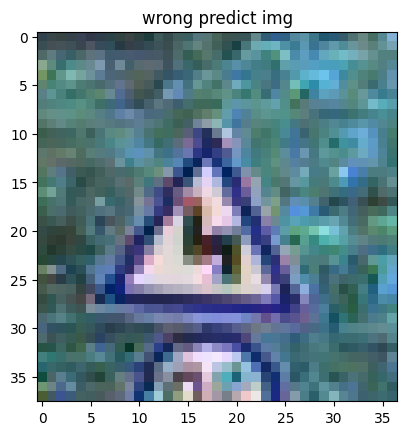

In [21]:
for i in range(0,len(labels)):
    if labels[i] !=svc_pred[i]:
        image = cv2.imread(data_dir + '/' +imgs[i])
        plt.title('wrong predict img')
        plt.imshow(image)
        break

In [22]:
# from xgboost import XGBClassifier
# clf_xgb = XGBClassifier()
# clf_xgb.fit(X_train_pca, y_train)
# y_pred = clf_xgb.predict(X_val_pca)
# accuracy = accuracy_score(y_val, y_pred)
# print(f'val XGB: {accuracy}')

In [23]:
# adaboost_pred = clf_xgb.predict(X_test_pca)
# print('adaboost Test Data accuracy: ',accuracy_score(labels,adaboost_pred))